Simple example where we have a Potts MRF and we blur it with independent Gaussian noise and we construct the posterior MRF to sample from and estimate the original Potts field (MPM cirterion)

In [1]:
# os.environ["JAX_PLATFORMS"] = "cpu"

Sample the truth X

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mrfx.samplers import ChromaticGibbsSampler
from mrfx.models import AbstractMarkovRandomFieldModel, Potts

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
K = 3
beta = 1.0
potts_model = Potts(K=K, beta=beta, neigh_size=1)

key, subkey = jax.random.split(key, 2)
lx = ly = 250
chro_gibbs = ChromaticGibbsSampler(
    lx=lx, ly=ly, eps=0.05, max_iter=1000, color_update_type="sequential_in_color"
)
X = chro_gibbs.run(potts_model, subkey)[1][-1]

Stopping Gibbs sampler, cause: Convergence criterion is reached


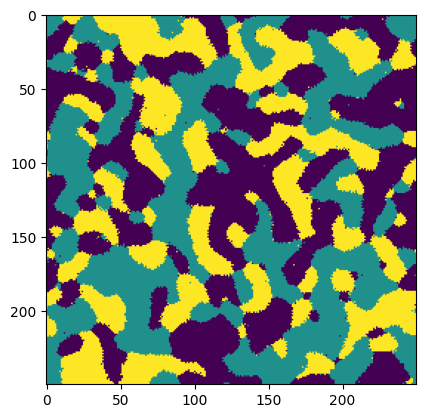

In [5]:
plt.imshow(X)
plt.show()

Sample the observations Y

In [6]:
from mrfx.models._GaussianIid import GaussianIid

mu = jnp.arange(K)
sigma = 0.5 * jnp.ones((K,))
cond_llkh = GaussianIid(
    mu=mu,
    sigma=sigma,
    prior_model=potts_model,
)

In [7]:
key, subkey = jax.random.split(key, 2)
Y = cond_llkh.sample(X, subkey)

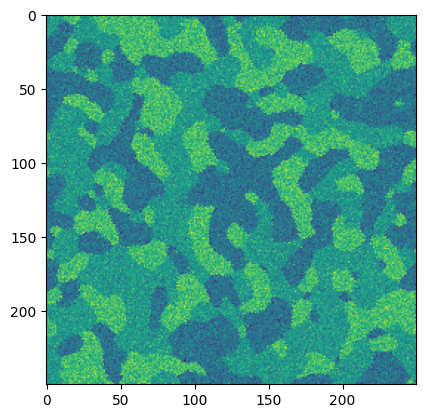

In [8]:
plt.imshow(Y)
plt.show()

Create the posterior field `mrfx` model. We need to define the attributes and the `potential` method.

In [9]:
import equinox as eqx
from jaxtyping import Float, Array
from mrfx.abstract import Params


class PosteriorFieldParameters(Params):
    beta: Float
    mu: Array
    sigma: Array


class PosteriorField(AbstractMarkovRandomFieldModel):
    """ """

    K: int = eqx.field(kw_only=True, static=True)
    neigh_size: int = eqx.field(kw_only=True, static=True, default=1)
    params: PosteriorFieldParameters = eqx.field(kw_only=True)
    Y: Array = eqx.field(kw_only=True)

    def potential(self, x: Array, neigh_values: Array, u: Array, v: Array) -> Float:
        return (
            self.params.beta * (x == neigh_values).sum(dtype=neigh_values.dtype)
            - (Y[u, v] - self.params.mu[x]) ** 2 / (2 * self.params.sigma[x] ** 2)
            - jnp.log(jnp.sqrt(2 * jnp.pi) * self.params.sigma[x])
        )


params = PosteriorFieldParameters(beta=beta, mu=mu, sigma=sigma)
post_field = PosteriorField(K=K, params=params, Y=Y)

In [10]:
from mrfx.estimators import mpm_estimator

key, subkey = jax.random.split(key, 2)
X_MPM = mpm_estimator(chro_gibbs, post_field, K, 15, subkey)

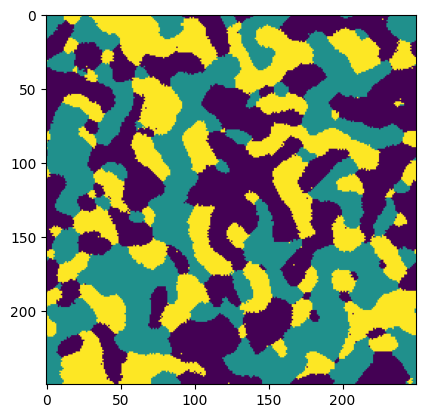

In [11]:
plt.imshow(X_MPM)
plt.show()

In [12]:
print("Error rate between X and X_MPM", (X.flatten() != X_MPM.flatten()).mean())

Error rate between X and X_MPM 0.020704


That was easy because all parameters are known